In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import random
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import time

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from keras.metrics import Precision, Recall, F1Score
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model, to_categorical
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)      # suppress messages from Tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from hashlib import md5

In [2]:
def df_shrink(df, obj2cat=False, int2uint=False):
    # Giảm bộ nhớ cho DataFrame
    
    df_copy = df.copy()
    
    # Xử lý các cột integer
    for col in df_copy.select_dtypes(include=['int64']).columns:
        if int2uint:
            # Chuyển sang unsigned integer nếu được bật
            df_copy[col] = pd.to_numeric(df_copy[col], downcast='unsigned')
        else:
            # Chuyển sang integer nhỏ hơn
            df_copy[col] = pd.to_numeric(df_copy[col], downcast='integer')
    
    # Xử lý các cột float
    for col in df_copy.select_dtypes(include=['float64']).columns:
        df_copy[col] = pd.to_numeric(df_copy[col], downcast='float')
    
    # Chuyển đổi các cột object sang category nếu được bật
    if obj2cat:
        for col in df_copy.select_dtypes(include=['object']).columns:
            df_copy[col] = df_copy[col].astype('category')
    
    return df_copy

In [3]:
# Function to create a hash for each column
def hash_column(series):
    return md5(pd.util.hash_pandas_object(series, index=False).values).hexdigest()

# Function to find columns with identical hashes
def find_identical_columns_by_hash(df):
    hash_dict = {}
    for col in df.columns:
        col_hash = hash_column(df[col])
        if col_hash in hash_dict:
            hash_dict[col_hash].append(col)
        else:
            hash_dict[col_hash] = [col]

    return [cols for cols in hash_dict.values() if len(cols) > 1]


In [4]:
# Tải và tiền xử lý dữ liệu
def load_and_preprocess_data():
    # Đọc dữ liệu
    print("Loading data...")
    df = pd.read_csv("/kaggle/input/edge-iiot/processed_IIoT.csv")
    df.info()

    # Phân tích dữ liệu ban đầu
    print("\nInitial data analysis:")
    print(f"Total samples: {len(df)}")
    print("\nClass distribution:")
    print(df['Attack_type'].value_counts())

    # Xử lý dữ liệu 

    # Applying the hash function to the DataFrame
    identical_column_groups = find_identical_columns_by_hash(df)
    print("Groups of identical columns:", identical_column_groups)
    
    # Iterate through the list of groups and drop all 
    for group in identical_column_groups:
        df = df.drop(group, axis=1)
        
    df = df_shrink(df, obj2cat=False, int2uint=False)
    print("Data info after shrinking memory:")
    df.info()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)   
    df.dropna(axis=0, how='any', inplace=True)
    df.drop_duplicates(subset=None, keep="first", inplace=True)
    df = shuffle(df)

    # Chuyển đổi các cột không phải số thành số bằng Label Encoding
    for column in df.select_dtypes(include=['object']).columns:
      df[column] = df[column].astype(str)
      le = LabelEncoder()
      df[column] = le.fit_transform(df[column])
    
    # Tách features và target
    X = df.drop(['Attack_type'], axis=1)
    y = df['Attack_type']

    print(f"Features after removal: {X.shape[1]}")
    
    # One-hot encoding cho target
    y = to_categorical(y)

    return X, y

In [5]:
# Tiền xử lý dữ liệu
X, y = load_and_preprocess_data()

# Chia dữ liệu thành tập huấn luyện, kiểm tra và xác thực
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, stratify=y_train)

# Chuẩn hóa các đặc trưng
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Reshape cho CNN (thêm channel dimension)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# In thông tin về shape của data
print("\nData shapes:")
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
    
# Kiểm tra phân phối classes trong từng tập
print("\nClass distribution in splits:")
print("Training set:", np.sum(y_train, axis=0))
print("Validation set:", np.sum(y_val, axis=0))
print("Test set:", np.sum(y_test, axis=0))

Loading data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1921663 entries, 0 to 1921662
Data columns (total 96 columns):
 #   Column                                                                                                Dtype  
---  ------                                                                                                -----  
 0   arp.opcode                                                                                            float64
 1   arp.hw.size                                                                                           float64
 2   icmp.checksum                                                                                         float64
 3   icmp.seq_le                                                                                           float64
 4   icmp.unused                                                                                           float64
 5   http.content_length                                          

In [6]:
# Định nghĩa kích thước đầu vào và số lớp đầu ra
input_shape = (X_train.shape[1], 1)
output_classes = 15

In [7]:
# Hàm tạo mô hình CNN 1D
def create_1d_cnn_model(params):
    model = Sequential()

    current_filters = params['num_filters']
    for i in range(params['num_conv_layers']):
        if i == 0:
            # Lớp đầu tiên cần chỉ định input_shape
            model.add(Conv1D(filters=current_filters, 
                           kernel_size=params['kernel_size'], 
                           activation='relu',
                           padding='same',
                           input_shape=(input_shape)))
        else:
            # Các lớp tiếp theo
            model.add(Conv1D(filters=current_filters, 
                           kernel_size=params['kernel_size'], 
                           activation='relu',
                           padding='same'))
        model.add(MaxPooling1D(pool_size=params['pooling_size'], padding='same'))
        current_filters *= 2  # Tăng số filters gấp đôi sau mỗi lớp
    
    model.add(Flatten())

    current_neurons = params['num_neurons_in_dense_layers']
    for _ in range(params['num_dense_layers']):
        model.add(Dense(current_neurons, activation='relu'))
        model.add(Dropout(params['dropout_rate']))
        current_neurons = current_neurons // 2 # Giảm số neurons hai lần sau mỗi lớp

    model.add(Dense(output_classes, activation='softmax'))

    optimizer = Adam(learning_rate=params['learning_rate'])
    loss_function = 'categorical_crossentropy'
    model.compile(loss=loss_function, optimizer=optimizer,
                 metrics=['accuracy', 
                         Precision(name='precision'), 
                         Recall(name='recall'),
                         F1Score(name='f1')])

    return model

In [8]:
# Thông số PSO
n_particles = 5
c1 = 2
c2 = 2
bounds = [
    (1, 3),      # num_conv_layers 
    (0, 2),      # num_filters
    (0, 2),      # kernel_size
    (2, 5),      # pooling_size
    (1, 3),      # num_dense_layers 
    (0, 2),      # num_neurons_in_dense_layers
    (0.1, 0.5),  # dropout_rate
    (1e-5, 1e-2),# learning_rate
    (0, 4),      # batch_size
    (20, 50),    # num_epochs
    (5, 10)      # early-stopping_patience
]
particles = [np.random.uniform(low=bounds[i][0], high=bounds[i][1], size=n_particles) for i in range(len(bounds))]
velocities = [np.zeros(n_particles) for _ in range(len(bounds))]

In [9]:
# Chuyển vị trí thành tham số
def position_to_params(particles, i):
    params_keys = ['num_conv_layers',
               'num_filters', 
               'kernel_size', 
               'pooling_size', 
               'num_dense_layers', 
               'num_neurons_in_dense_layers', 
               'dropout_rate', 
               'learning_rate', 
               'batch_size', 
               'num_epochs', 
               'patience']
    params = {}
    for j, key in enumerate(params_keys):
        value = particles[j][i]
        if key in ['num_conv_layers','num_filters', 'kernel_size', 'pooling_size', 
                   'num_dense_layers', 'num_neurons_in_dense_layers', 
                   'batch_size', 'num_epochs', 'patience']:  
            value = int(round(value))
        if key == 'num_filters':
            value_choices = [16, 32, 64]
            value = value_choices[min(int(value), len(value_choices)-1)]
        if key == 'num_neurons_in_dense_layers':
            value_choices = [128, 256, 512]
            value = value_choices[min(int(value), len(value_choices)-1)]
        if key == 'batch_size':
            value_choices = [32, 64, 128, 256, 512]
            value = value_choices[min(int(value), len(value_choices)-1)]
        if key == 'kernel_size':
            value_choices = [3, 5, 7]
            value = value_choices[min(int(value), len(value_choices)-1)]
        params[key] = value
    return params

In [10]:
# Khởi tạo vị trí tốt nhất cá nhân và vị trí tốt nhất toàn cục
pbest_positions = [position_to_params(particles, i) for i in range(n_particles)]
pbest_fitnesses = [0] * n_particles
gbest_position = None
gbest_fitness = None

In [11]:
# Định nghĩa callback tùy chỉnh để theo dõi thời gian huấn luyện
class TimingCallback(keras.callbacks.Callback):
    def __init__(self):
        super(TimingCallback, self).__init__()
        self.epoch_times = []  # Lưu thời gian của từng epoch
        self.total_time = 0.0  # Tổng thời gian huấn luyện

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()  # Ghi lại thời gian bắt đầu của epoch

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.start_time  # Tính thời gian của epoch
        self.epoch_times.append(epoch_time)  # Lưu thời gian của epoch
        self.total_time += epoch_time  # Cộng dồn vào tổng thời gian
        print(f"\nThời gian huấn luyện cho epoch {epoch+1}: {epoch_time:.2f} giây")

    def on_train_end(self, logs=None):
        print(f"\nTổng thời gian huấn luyện cho vòng lặp: {self.total_time:.2f} giây")

In [12]:
# Hàm đánh giá độ thích nghi
def evaluate_fitness(params, particle_id=None, iteration=None):
    
    print(f"{'='*50}")
    if particle_id is not None and iteration is not None:
        print(f"Vòng lặp {iteration+1}, Cá thể {particle_id+1}")
    print("Tham số:")
    for key, value in params.items():
        print(f"{key}: {value}")
        
    model = create_1d_cnn_model(params)
    model.summary()

    # Tạo callback Early Stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_accuracy',      # Theo dõi validation accuracy
        patience=params['patience'], # Số epoch chờ đợi trước khi dừng
        mode='max',                  # Vì monitor là accuracy nên mode='max'
        restore_best_weights=True,   # Khôi phục trọng số tốt nhất
        verbose=1                    # In thông báo khi dừng
    )

    # Tạo callback để theo dõi thời gian huấn luyện
    timing_callback = TimingCallback()
    
    history = model.fit(X_train, y_train, 
                        batch_size=params['batch_size'], 
                        epochs=params['num_epochs'], 
                        verbose=1, 
                        validation_data=(X_val, y_val), 
                        callbacks=[early_stopping, timing_callback], 
                        shuffle=True)
    
    # Lấy lịch sử huấn luyện
    metrics_history = history.history

    # In danh sách các giá trị val_accuracy qua các epoch
    print("Danh sách các giá trị val_accuracy qua các epoch:")
    print(metrics_history['val_accuracy'])
    
    # Tìm epoch tốt nhất
    best_epoch = np.argmax(metrics_history['val_accuracy']) 
    
    # Lấy giá trị val_accuracy tại epoch tốt nhất
    val_acc_value = metrics_history['val_accuracy'][best_epoch]
    print(f"Giá trị val accuracy tại epoch tốt nhất (epoch {best_epoch+1}): {val_acc_value}")
    
    # Xử lý trường hợp value là tensor hoặc numpy array
    if isinstance(val_acc_value, tf.Tensor):
        val_acc_value = val_acc_value.numpy()
    if isinstance(val_acc_value, np.ndarray):
        if val_acc_value.size > 1:
            # Nếu mảng có nhiều hơn 1 phần tử, lấy phần tử có giá trị cao nhất 
            val_acc_value = np.max(val_acc_value)
        else:
            val_acc_value = val_acc_value.item()

    # Chuyển đổi sang float để đảm bảo tính toán chính xác
    val_acc_value = float(val_acc_value)

    # Lấy thời gian huấn luyện tổng cộng
    exec_time = timing_callback.total_time
    
    # Tính toán các thành phần fitness 
    lambda_value = 0.5  # λ = 0.5
    k = 0.001
    fitness_accuracy_component = val_acc_value
    fitness_time_component = 1 / np.exp(k * exec_time)
            
    # Tính fitness tổng hợp: F = λ.Acc + (1-λ).(1/e^(k*T))
    fitness = lambda_value * fitness_accuracy_component + (1 - lambda_value) * fitness_time_component
        
    print(f"\nĐánh giá fitness:")
    print(f"Thành phần accuracy: {lambda_value} * {fitness_accuracy_component:.4f} = {lambda_value * fitness_accuracy_component:.4f}")
    print(f"Thành phần thời gian: {1-lambda_value} * {fitness_time_component:.4f} = {(1-lambda_value) * fitness_time_component:.4f}")
    print(f"Fitness tổng hợp: {fitness:.4f}")

    # Lưu mô hình sau khi huấn luyện và đánh giá xong
    model_save_path = f"model_iter_{iteration+1}_part_{particle_id+1}.h5"
    print("Đang lưu mô hình sau khi huấn luyện xong...")
    model.save(model_save_path)
    print(f"Mô hình đã được lưu thành công tại: {model_save_path}\n")
    
    return {
        'model': model,
        'fitness': fitness,
        'history': metrics_history,
        'total_time': exec_time
    }

In [13]:
best_model = None
best_model_path = 'best_1d-cnn-pso_model.h5'
best_model_history = None

# Bắt đầu đo thời gian
start_time = time.time()

# Tối ưu hóa PSO
params_keys = ['num_conv_layers',
               'num_filters', 
               'kernel_size', 
               'pooling_size', 
               'num_dense_layers', 
               'num_neurons_in_dense_layers', 
               'dropout_rate', 
               'learning_rate', 
               'batch_size', 
               'num_epochs', 
               'patience']

print("=== Khởi tạo quần thể ===")
print("=== Bắt đầu quá trình tối ưu hóa PSO ===")

# Khởi tạo biến theo dõi điều kiện dừng
previous_gbest_fitness = None
no_improvement_count = 0
iteration = 0
    
while True:
    print(f"\nVòng lặp {iteration + 1}")
    
    for i in range(n_particles):
        params = position_to_params(particles, i)
        result = evaluate_fitness(params, i, iteration)
        fitness = result['fitness']

        if fitness > pbest_fitnesses[i]:
            pbest_fitnesses[i] = fitness
            pbest_positions[i] = params.copy()
            print(f"Cập nhật pbest cho cá thể {i+1}: {fitness:.4f}")

        if gbest_fitness is None or fitness > gbest_fitness:
            gbest_fitness = fitness
            gbest_position = params.copy()
            best_model = result['model']
            best_model.save(best_model_path, overwrite=True)
            best_model_history = result['history']
            print(f"Cập nhật gbest: {fitness:.4f}")
            
    print(f"Kết quả sau vòng lặp tối ưu {iteration + 1}:")

    # Kiểm tra điều kiện dừng
    if previous_gbest_fitness is not None:
        improvement = gbest_fitness - previous_gbest_fitness
        if improvement > 0:
            if improvement <= 1e-4:
                no_improvement_count += 1
                print(f"Độ cải thiện không đáng kể (nhỏ hơn ngưỡng 1e-4)")
            else:
                no_improvement_count = 0
                print(f"Best fitness global: {gbest_fitness:.4f}")
                print("Best parameters global:")
                for key, value in gbest_position.items():
                    print(f"{key}: {value}")
                print(f"Độ cải thiện so với vòng lặp trước: {improvement:.4f}")
        else:
            print("Không có sự cải thiện so với vòng lặp trước")
            no_improvement_count += 1
        
        if no_improvement_count >= 3:
            print("\n=== Đã đạt điều kiện dừng - Kết thúc tối ưu hóa ===")
            break
    else:
        print(f"Best fitness global: {gbest_fitness:.4f}")
        print("Best parameters global:")
        for key, value in gbest_position.items():
            print(f"{key}: {value}")
    
    previous_gbest_fitness = gbest_fitness
    
    for i in range(n_particles):
        for j, key in enumerate(params_keys):
            r1, r2 = np.random.random(), np.random.random()
            velocities[j][i] = 0.5 * velocities[j][i] + c1 * r1 * (pbest_positions[i][key] - particles[j][i]) + c2 * r2 * (gbest_position[key] - particles[j][i])
            particles[j][i] += velocities[j][i]
            particles[j][i] = np.clip(particles[j][i], bounds[j][0], bounds[j][1])

    iteration += 1

# Kết thúc đo thời gian
end_time = time.time()

# Tính và in ra thời gian thực thi
execution_time = end_time - start_time
print(f"\nThời gian thực thi tổng thể: {execution_time:.2f} giây")

=== Khởi tạo quần thể ===
=== Bắt đầu quá trình tối ưu hóa PSO ===

Vòng lặp 1
Vòng lặp 1, Cá thể 1
Tham số:
num_conv_layers: 1
num_filters: 16
kernel_size: 5
pooling_size: 3
num_dense_layers: 1
num_neurons_in_dense_layers: 256
dropout_rate: 0.42750791405763056
learning_rate: 0.0019528610961129151
batch_size: 128
num_epochs: 50
patience: 7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 86, 16)              │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 29, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 464)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         119,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,991 (480.43 KB)

 Trainable params: 122,991 (480.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10509/10509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9258 - f1: 0.6318 - loss: 0.1799 - precision: 0.9609 - recall: 0.8984
Thời gian huấn luyện cho epoch 1: 32.65 giây
10509/10509 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.9258 - f1: 0.6318 - loss: 0.1799 - precision: 0.9609 - recall: 0.8984 - val_accuracy: 0.9366 - val_f1: 0.6881 - val_loss: 0.1336 - val_precision: 0.9715 - val_recall: 0.9118
Epoch 2/50
10486/10509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9353 - f1: 0.6975 - loss: 0.1392 - precision: 0.9717 - recall: 0.9088
Thời gian huấn luyện cho epoch 2: 24.74 giây
10509/10509 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9353 - f1: 0.6975 - loss: 0.1392 - precision: 0.9717 - recall: 0.9088 - val_accuracy: 0.9410 - val_f1: 0.7250 - val_loss: 0.1244 - val_precision: 0.9828 - val_recall: 0.9067
Epoch 3/50
10486/10509 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9378 - f1: 0.7162 - loss: 0.1336 - precision: 0.9741 - recall: 0.9113
Thời gian huấn luyện c

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 86, 32)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 22, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 704)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         180,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 215,567 (842.06 KB)

 Trainable params: 215,567 (842.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/41
10509/10509 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9245 - f1: 0.6275 - loss: 0.1838 - precision: 0.9610 - recall: 0.8958
Thời gian huấn luyện cho epoch 1: 37.34 giây
10509/10509 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.9245 - f1: 0.6275 - loss: 0.1838 - precision: 0.9610 - recall: 0.8958 - val_accuracy: 0.9348 - val_f1: 0.6678 - val_loss: 0.1390 - val_precision: 0.9711 - val_recall: 0.9086
Epoch 2/41
10509/10509 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9363 - f1: 0.7064 - loss: 0.1347 - precision: 0.9719 - recall: 0.9102
Thời gian huấn luyện cho epoch 2: 28.42 giây
10509/10509 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.9363 - f1: 0.7064 - loss: 0.1347 - precision: 0.9719 - recall: 0.9102 - val_accuracy: 0.9420 - val_f1: 0.7336 - val_loss: 0.1223 - val_precision: 0.9748 - val_recall: 0.9175
Epoch 3/41
10499/10509 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9407 - f1: 0.7348 - loss: 0.1253 - precision: 0.9750 - recall: 0.9154
Thời gian huấn luyện c

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │         352,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 15)                  │             975 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 362,127 (1.38 MB)

 Trainable params: 362,127 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/29
10509/10509 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9222 - f1: 0.6015 - loss: 0.2003 - precision: 0.9592 - recall: 0.8956
Thời gian huấn luyện cho epoch 1: 38.02 giây
10509/10509 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.9222 - f1: 0.6015 - loss: 0.2003 - precision: 0.9592 - recall: 0.8956 - val_accuracy: 0.9313 - val_f1: 0.6424 - val_loss: 0.1430 - val_precision: 0.9718 - val_recall: 0.9057
Epoch 2/29
10490/10509 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9287 - f1: 0.6421 - loss: 0.1685 - precision: 0.9660 - recall: 0.9032
Thời gian huấn luyện cho epoch 2: 29.50 giây
10509/10509 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.9287 - f1: 0.6420 - loss: 0.1685 - precision: 0.9660 - recall: 0.9032 - val_accuracy: 0.9304 - val_f1: 0.6128 - val_loss: 0.1535 - val_precision: 0.9665 - val_recall: 0.9053
Epoch 3/29
10492/10509 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9291 - f1: 0.6347 - loss: 0.1670 - precision: 0.9647 - recall: 0.9048
Thời gian huấn luyện c

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 86, 64)              │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 22, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 6, 256)              │         164,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 475,919 (1.82 MB)

 Trainable params: 475,919 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9208 - f1: 0.6010 - loss: 0.2090 - precision: 0.9608 - recall: 0.8923
Thời gian huấn luyện cho epoch 1: 72.65 giây
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 73s 3ms/step - accuracy: 0.9208 - f1: 0.6010 - loss: 0.2090 - precision: 0.9608 - recall: 0.8923 - val_accuracy: 0.9277 - val_f1: 0.6049 - val_loss: 0.2120 - val_precision: 0.9732 - val_recall: 0.8958
Epoch 2/30
21006/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9161 - f1: 0.5768 - loss: 0.2783 - precision: 0.9650 - recall: 0.8840
Thời gian huấn luyện cho epoch 2: 62.40 giây
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 0.9161 - f1: 0.5768 - loss: 0.2783 - precision: 0.9650 - recall: 0.8840 - val_accuracy: 0.9118 - val_f1: 0.5002 - val_loss: 0.2387 - val_precision: 0.9527 - val_recall: 0.8855
Epoch 3/30
21002/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9105 - f1: 0.5441 - loss: 0.2739 - precision: 0.9650 - recall: 0.8790
Thời gian huấn luyện c

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 86, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 29, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 190,863 (745.56 KB)

 Trainable params: 190,863 (745.56 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/26
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9262 - f1: 0.6342 - loss: 0.1761 - precision: 0.9631 - recall: 0.8983
Thời gian huấn luyện cho epoch 1: 68.55 giây
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - accuracy: 0.9262 - f1: 0.6342 - loss: 0.1761 - precision: 0.9631 - recall: 0.8984 - val_accuracy: 0.9432 - val_f1: 0.7494 - val_loss: 0.1156 - val_precision: 0.9806 - val_recall: 0.9177
Epoch 2/26
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9410 - f1: 0.7404 - loss: 0.1252 - precision: 0.9765 - recall: 0.9158
Thời gian huấn luyện cho epoch 2: 61.06 giây
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 61s 3ms/step - accuracy: 0.9410 - f1: 0.7404 - loss: 0.1252 - precision: 0.9765 - recall: 0.9158 - val_accuracy: 0.9439 - val_f1: 0.7448 - val_loss: 0.1148 - val_precision: 0.9766 - val_recall: 0.9209
Epoch 3/26
21012/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9419 - f1: 0.7511 - loss: 0.1450 - precision: 0.9783 - recall: 0.9159
Thời gian huấn luyện c

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)                    │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9244 - f1: 0.6328 - loss: 0.1808 - precision: 0.9605 - recall: 0.8971
Thời gian huấn luyện cho epoch 1: 21.41 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9244 - f1: 0.6328 - loss: 0.1808 - precision: 0.9605 - recall: 0.8971 - val_accuracy: 0.9377 - val_f1: 0.6879 - val_loss: 0.1353 - val_precision: 0.9720 - val_recall: 0.9124
Epoch 2/30
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9368 - f1: 0.7089 - loss: 0.1353 - precision: 0.9723 - recall: 0.9105
Thời gian huấn luyện cho epoch 2: 12.07 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9368 - f1: 0.7089 - loss: 0.1352 - precision: 0.9723 - recall: 0.9105 - val_accuracy: 0.9474 - val_f1: 0.7802 - val_loss: 0.1118 - val_precision: 0.9823 - val_recall: 0.9214
Epoch 3/30
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9434 - f1: 0.7654 - loss: 0.1204 - precision: 0.9784 - recall: 0.9183
Thời gian huấn luyện cho epoch 3

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)                    │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 1856)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 512)                 │         950,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,086,479 (4.14 MB)

 Trainable params: 1,086,479 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9192 - f1: 0.5938 - loss: 0.2209 - precision: 0.9556 - recall: 0.8900
Thời gian huấn luyện cho epoch 1: 18.30 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9192 - f1: 0.5938 - loss: 0.2208 - precision: 0.9556 - recall: 0.8900 - val_accuracy: 0.9288 - val_f1: 0.6184 - val_loss: 0.1594 - val_precision: 0.9309 - val_recall: 0.9271
Epoch 2/35
2619/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9257 - f1: 0.6166 - loss: 0.1877 - precision: 0.9611 - recall: 0.9025
Thời gian huấn luyện cho epoch 2: 11.17 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9257 - f1: 0.6166 - loss: 0.1877 - precision: 0.9611 - recall: 0.9025 - val_accuracy: 0.9321 - val_f1: 0.6380 - val_loss: 0.1600 - val_precision: 0.9686 - val_recall: 0.9050
Epoch 3/35
2619/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9265 - f1: 0.6227 - loss: 0.1873 - precision: 0.9628 - recall: 0.9018
Thời gian huấn luyện cho epoch 3

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/29
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9204 - f1: 0.6012 - loss: 0.2148 - precision: 0.9584 - recall: 0.8920
Thời gian huấn luyện cho epoch 1: 19.06 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9204 - f1: 0.6012 - loss: 0.2148 - precision: 0.9584 - recall: 0.8920 - val_accuracy: 0.9310 - val_f1: 0.6395 - val_loss: 0.1515 - val_precision: 0.9665 - val_recall: 0.9074
Epoch 2/29
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9293 - f1: 0.6432 - loss: 0.1592 - precision: 0.9638 - recall: 0.9052
Thời gian huấn luyện cho epoch 2: 12.12 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9293 - f1: 0.6432 - loss: 0.1592 - precision: 0.9638 - recall: 0.9052 - val_accuracy: 0.9326 - val_f1: 0.6363 - val_loss: 0.1435 - val_precision: 0.9685 - val_recall: 0.9085
Epoch 3/29
2620/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9302 - f1: 0.6484 - loss: 0.1593 - precision: 0.9637 - recall: 0.9070
Thời gian huấn luyện cho epoch 3

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/29
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9217 - f1: 0.6078 - loss: 0.2067 - precision: 0.9591 - recall: 0.8936
Thời gian huấn luyện cho epoch 1: 19.06 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9217 - f1: 0.6078 - loss: 0.2067 - precision: 0.9591 - recall: 0.8936 - val_accuracy: 0.9313 - val_f1: 0.6312 - val_loss: 0.1424 - val_precision: 0.9683 - val_recall: 0.9062
Epoch 2/29
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9306 - f1: 0.6426 - loss: 0.1502 - precision: 0.9653 - recall: 0.9059
Thời gian huấn luyện cho epoch 2: 12.16 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9306 - f1: 0.6426 - loss: 0.1502 - precision: 0.9653 - recall: 0.9059 - val_accuracy: 0.9361 - val_f1: 0.6732 - val_loss: 0.1337 - val_precision: 0.9696 - val_recall: 0.9095
Epoch 3/29
2623/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9325 - f1: 0.6554 - loss: 0.1485 - precision: 0.9670 - recall: 0.9071
Thời gian huấn luyện cho epoch 3

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/28
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9249 - f1: 0.6323 - loss: 0.1824 - precision: 0.9623 - recall: 0.8985
Thời gian huấn luyện cho epoch 1: 18.95 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9249 - f1: 0.6324 - loss: 0.1824 - precision: 0.9623 - recall: 0.8985 - val_accuracy: 0.9390 - val_f1: 0.7156 - val_loss: 0.1304 - val_precision: 0.9798 - val_recall: 0.9045
Epoch 2/28
2618/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9374 - f1: 0.7073 - loss: 0.1377 - precision: 0.9731 - recall: 0.9109
Thời gian huấn luyện cho epoch 2: 12.48 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9374 - f1: 0.7073 - loss: 0.1377 - precision: 0.9731 - recall: 0.9109 - val_accuracy: 0.9405 - val_f1: 0.7076 - val_loss: 0.1251 - val_precision: 0.9763 - val_recall: 0.9153
Epoch 3/28
2625/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9398 - f1: 0.7328 - loss: 0.1252 - precision: 0.9745 - recall: 0.9145
Thời gian huấn luyện cho epoch 3

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_13 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9245 - f1: 0.6300 - loss: 0.1833 - precision: 0.9611 - recall: 0.8980
Thời gian huấn luyện cho epoch 1: 18.27 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9245 - f1: 0.6300 - loss: 0.1833 - precision: 0.9611 - recall: 0.8980 - val_accuracy: 0.9366 - val_f1: 0.7039 - val_loss: 0.1373 - val_precision: 0.9735 - val_recall: 0.9071
Epoch 2/20
2620/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9359 - f1: 0.6985 - loss: 0.1397 - precision: 0.9707 - recall: 0.9097
Thời gian huấn luyện cho epoch 2: 12.00 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9359 - f1: 0.6986 - loss: 0.1397 - precision: 0.9707 - recall: 0.9097 - val_accuracy: 0.9398 - val_f1: 0.7091 - val_loss: 0.1262 - val_precision: 0.9751 - val_recall: 0.9147
Epoch 3/20
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9380 - f1: 0.7141 - loss: 0.1292 - precision: 0.9742 - recall: 0.9118
Thời gian huấn luyện cho epoch 3

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/23
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9246 - f1: 0.6218 - loss: 0.1862 - precision: 0.9603 - recall: 0.8978
Thời gian huấn luyện cho epoch 1: 18.54 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9246 - f1: 0.6218 - loss: 0.1862 - precision: 0.9603 - recall: 0.8978 - val_accuracy: 0.9328 - val_f1: 0.6210 - val_loss: 0.1419 - val_precision: 0.9723 - val_recall: 0.8999
Epoch 2/23
2620/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9333 - f1: 0.6664 - loss: 0.1447 - precision: 0.9696 - recall: 0.9062
Thời gian huấn luyện cho epoch 2: 12.40 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9333 - f1: 0.6664 - loss: 0.1447 - precision: 0.9696 - recall: 0.9062 - val_accuracy: 0.9373 - val_f1: 0.6788 - val_loss: 0.1312 - val_precision: 0.9740 - val_recall: 0.9110
Epoch 3/23
2616/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9356 - f1: 0.6884 - loss: 0.1361 - precision: 0.9724 - recall: 0.9087
Thời gian huấn luyện cho epoch 3

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_15 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/27
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9231 - f1: 0.6192 - loss: 0.1929 - precision: 0.9606 - recall: 0.8959
Thời gian huấn luyện cho epoch 1: 18.90 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9231 - f1: 0.6192 - loss: 0.1929 - precision: 0.9606 - recall: 0.8959 - val_accuracy: 0.9351 - val_f1: 0.6732 - val_loss: 0.1364 - val_precision: 0.9683 - val_recall: 0.9105
Epoch 2/27
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9332 - f1: 0.6699 - loss: 0.1509 - precision: 0.9688 - recall: 0.9063
Thời gian huấn luyện cho epoch 2: 12.23 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9332 - f1: 0.6699 - loss: 0.1509 - precision: 0.9688 - recall: 0.9063 - val_accuracy: 0.9381 - val_f1: 0.6989 - val_loss: 0.1544 - val_precision: 0.9706 - val_recall: 0.9137
Epoch 3/27
2616/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9339 - f1: 0.6887 - loss: 0.1711 - precision: 0.9679 - recall: 0.9083
Thời gian huấn luyện cho epoch 3

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_16 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/27
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9248 - f1: 0.6338 - loss: 0.1786 - precision: 0.9613 - recall: 0.8991
Thời gian huấn luyện cho epoch 1: 18.13 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9248 - f1: 0.6338 - loss: 0.1786 - precision: 0.9613 - recall: 0.8991 - val_accuracy: 0.9348 - val_f1: 0.6739 - val_loss: 0.1331 - val_precision: 0.9722 - val_recall: 0.9054
Epoch 2/27
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9376 - f1: 0.7133 - loss: 0.1351 - precision: 0.9733 - recall: 0.9108
Thời gian huấn luyện cho epoch 2: 12.28 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9376 - f1: 0.7133 - loss: 0.1351 - precision: 0.9733 - recall: 0.9108 - val_accuracy: 0.9452 - val_f1: 0.7663 - val_loss: 0.1261 - val_precision: 0.9832 - val_recall: 0.9134
Epoch 3/27
2619/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9408 - f1: 0.7436 - loss: 0.1266 - precision: 0.9761 - recall: 0.9148
Thời gian huấn luyện cho epoch 3

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_17 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_17 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/29
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9242 - f1: 0.6314 - loss: 0.1835 - precision: 0.9611 - recall: 0.8979
Thời gian huấn luyện cho epoch 1: 18.27 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9242 - f1: 0.6314 - loss: 0.1835 - precision: 0.9611 - recall: 0.8979 - val_accuracy: 0.9361 - val_f1: 0.6859 - val_loss: 0.1352 - val_precision: 0.9718 - val_recall: 0.9104
Epoch 2/29
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9366 - f1: 0.7033 - loss: 0.1349 - precision: 0.9717 - recall: 0.9113
Thời gian huấn luyện cho epoch 2: 12.36 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9366 - f1: 0.7033 - loss: 0.1349 - precision: 0.9717 - recall: 0.9113 - val_accuracy: 0.9476 - val_f1: 0.7824 - val_loss: 0.1093 - val_precision: 0.9893 - val_recall: 0.9132
Epoch 3/29
2627/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9433 - f1: 0.7675 - loss: 0.1177 - precision: 0.9796 - recall: 0.9170
Thời gian huấn luyện cho epoch 3

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_18 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9227 - f1: 0.6192 - loss: 0.1902 - precision: 0.9604 - recall: 0.8957
Thời gian huấn luyện cho epoch 1: 18.44 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9227 - f1: 0.6192 - loss: 0.1902 - precision: 0.9604 - recall: 0.8957 - val_accuracy: 0.9352 - val_f1: 0.6722 - val_loss: 0.1418 - val_precision: 0.9695 - val_recall: 0.9091
Epoch 2/25
2621/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9317 - f1: 0.6564 - loss: 0.1499 - precision: 0.9654 - recall: 0.9073
Thời gian huấn luyện cho epoch 2: 12.10 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9317 - f1: 0.6564 - loss: 0.1499 - precision: 0.9654 - recall: 0.9073 - val_accuracy: 0.9366 - val_f1: 0.6776 - val_loss: 0.1302 - val_precision: 0.9707 - val_recall: 0.9123
Epoch 3/25
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9365 - f1: 0.6937 - loss: 0.1339 - precision: 0.9690 - recall: 0.9129
Thời gian huấn luyện cho epoch 3

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_19 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_19 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 1856)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 512)                 │         950,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,086,479 (4.14 MB)

 Trainable params: 1,086,479 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/26
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9221 - f1: 0.6133 - loss: 0.1958 - precision: 0.9594 - recall: 0.8936
Thời gian huấn luyện cho epoch 1: 17.95 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.9221 - f1: 0.6133 - loss: 0.1958 - precision: 0.9595 - recall: 0.8936 - val_accuracy: 0.9301 - val_f1: 0.5931 - val_loss: 0.1466 - val_precision: 0.9538 - val_recall: 0.9148
Epoch 2/26
2620/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9328 - f1: 0.6609 - loss: 0.1481 - precision: 0.9682 - recall: 0.9062
Thời gian huấn luyện cho epoch 2: 11.43 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9329 - f1: 0.6609 - loss: 0.1481 - precision: 0.9682 - recall: 0.9062 - val_accuracy: 0.9396 - val_f1: 0.7159 - val_loss: 0.1264 - val_precision: 0.9729 - val_recall: 0.9155
Epoch 3/26
2621/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9378 - f1: 0.7097 - loss: 0.1344 - precision: 0.9737 - recall: 0.9116
Thời gian huấn luyện cho epoch 3

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_20 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_20 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/29
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9248 - f1: 0.6351 - loss: 0.1788 - precision: 0.9613 - recall: 0.8977
Thời gian huấn luyện cho epoch 1: 19.20 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9248 - f1: 0.6351 - loss: 0.1787 - precision: 0.9613 - recall: 0.8977 - val_accuracy: 0.9366 - val_f1: 0.7008 - val_loss: 0.1327 - val_precision: 0.9716 - val_recall: 0.9099
Epoch 2/29
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9376 - f1: 0.7139 - loss: 0.1323 - precision: 0.9727 - recall: 0.9112
Thời gian huấn luyện cho epoch 2: 12.19 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9376 - f1: 0.7139 - loss: 0.1323 - precision: 0.9727 - recall: 0.9112 - val_accuracy: 0.9470 - val_f1: 0.7902 - val_loss: 0.1112 - val_precision: 0.9841 - val_recall: 0.9190
Epoch 3/29
2627/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9449 - f1: 0.7786 - loss: 0.1147 - precision: 0.9801 - recall: 0.9189
Thời gian huấn luyện cho epoch 3

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_21 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_18 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/27
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9237 - f1: 0.6352 - loss: 0.1806 - precision: 0.9603 - recall: 0.8971
Thời gian huấn luyện cho epoch 1: 18.47 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9237 - f1: 0.6353 - loss: 0.1805 - precision: 0.9603 - recall: 0.8971 - val_accuracy: 0.9365 - val_f1: 0.6735 - val_loss: 0.1277 - val_precision: 0.9718 - val_recall: 0.9104
Epoch 2/27
2619/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9403 - f1: 0.7389 - loss: 0.1266 - precision: 0.9756 - recall: 0.9138
Thời gian huấn luyện cho epoch 2: 12.21 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9403 - f1: 0.7389 - loss: 0.1266 - precision: 0.9757 - recall: 0.9138 - val_accuracy: 0.9470 - val_f1: 0.7825 - val_loss: 0.1106 - val_precision: 0.9810 - val_recall: 0.9219
Epoch 3/27
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9456 - f1: 0.7818 - loss: 0.1134 - precision: 0.9808 - recall: 0.9195
Thời gian huấn luyện cho epoch 3

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_22 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_22 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_19 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9243 - f1: 0.6275 - loss: 0.1850 - precision: 0.9612 - recall: 0.8980
Thời gian huấn luyện cho epoch 1: 18.64 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9243 - f1: 0.6275 - loss: 0.1850 - precision: 0.9612 - recall: 0.8980 - val_accuracy: 0.9335 - val_f1: 0.6563 - val_loss: 0.1352 - val_precision: 0.9739 - val_recall: 0.9055
Epoch 2/30
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9366 - f1: 0.7046 - loss: 0.1353 - precision: 0.9716 - recall: 0.9105
Thời gian huấn luyện cho epoch 2: 12.15 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9366 - f1: 0.7047 - loss: 0.1353 - precision: 0.9716 - recall: 0.9106 - val_accuracy: 0.9438 - val_f1: 0.7407 - val_loss: 0.1176 - val_precision: 0.9770 - val_recall: 0.9194
Epoch 3/30
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9430 - f1: 0.7611 - loss: 0.1184 - precision: 0.9791 - recall: 0.9166
Thời gian huấn luyện cho epoch 3

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_23 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_23 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_20 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/33
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9247 - f1: 0.6333 - loss: 0.1829 - precision: 0.9613 - recall: 0.8992
Thời gian huấn luyện cho epoch 1: 18.25 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9247 - f1: 0.6333 - loss: 0.1829 - precision: 0.9613 - recall: 0.8992 - val_accuracy: 0.9353 - val_f1: 0.6795 - val_loss: 0.1429 - val_precision: 0.9689 - val_recall: 0.9102
Epoch 2/33
2621/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9349 - f1: 0.6878 - loss: 0.1414 - precision: 0.9694 - recall: 0.9088
Thời gian huấn luyện cho epoch 2: 12.08 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9349 - f1: 0.6878 - loss: 0.1414 - precision: 0.9694 - recall: 0.9088 - val_accuracy: 0.9452 - val_f1: 0.7734 - val_loss: 0.1187 - val_precision: 0.9799 - val_recall: 0.9201
Epoch 3/33
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9417 - f1: 0.7575 - loss: 0.1237 - precision: 0.9767 - recall: 0.9159
Thời gian huấn luyện cho epoch 3

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_24 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_21 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/34
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9241 - f1: 0.6253 - loss: 0.1837 - precision: 0.9620 - recall: 0.8972
Thời gian huấn luyện cho epoch 1: 19.34 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9241 - f1: 0.6253 - loss: 0.1837 - precision: 0.9620 - recall: 0.8972 - val_accuracy: 0.9370 - val_f1: 0.6968 - val_loss: 0.1344 - val_precision: 0.9710 - val_recall: 0.9127
Epoch 2/34
2617/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9348 - f1: 0.6909 - loss: 0.1434 - precision: 0.9698 - recall: 0.9084
Thời gian huấn luyện cho epoch 2: 12.11 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9348 - f1: 0.6910 - loss: 0.1435 - precision: 0.9698 - recall: 0.9084 - val_accuracy: 0.9412 - val_f1: 0.7336 - val_loss: 0.1265 - val_precision: 0.9791 - val_recall: 0.9158
Epoch 3/34
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9406 - f1: 0.7461 - loss: 0.1394 - precision: 0.9757 - recall: 0.9146
Thời gian huấn luyện cho epoch 3

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_25 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_25 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_22 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/31
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9253 - f1: 0.6360 - loss: 0.1829 - precision: 0.9616 - recall: 0.8987
Thời gian huấn luyện cho epoch 1: 18.23 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9253 - f1: 0.6360 - loss: 0.1829 - precision: 0.9616 - recall: 0.8987 - val_accuracy: 0.9347 - val_f1: 0.6632 - val_loss: 0.1347 - val_precision: 0.9655 - val_recall: 0.9127
Epoch 2/31
2619/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9356 - f1: 0.7005 - loss: 0.1363 - precision: 0.9712 - recall: 0.9089
Thời gian huấn luyện cho epoch 2: 12.39 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9356 - f1: 0.7006 - loss: 0.1363 - precision: 0.9712 - recall: 0.9089 - val_accuracy: 0.9433 - val_f1: 0.7495 - val_loss: 0.1179 - val_precision: 0.9786 - val_recall: 0.9181
Epoch 3/31
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9416 - f1: 0.7614 - loss: 0.1229 - precision: 0.9777 - recall: 0.9149
Thời gian huấn luyện cho epoch 3

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_26 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_26 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_23 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9248 - f1: 0.6296 - loss: 0.1778 - precision: 0.9618 - recall: 0.8990
Thời gian huấn luyện cho epoch 1: 18.91 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9248 - f1: 0.6296 - loss: 0.1778 - precision: 0.9618 - recall: 0.8990 - val_accuracy: 0.9340 - val_f1: 0.6664 - val_loss: 0.1403 - val_precision: 0.9704 - val_recall: 0.9097
Epoch 2/32
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9371 - f1: 0.7113 - loss: 0.1349 - precision: 0.9718 - recall: 0.9115
Thời gian huấn luyện cho epoch 2: 12.15 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9371 - f1: 0.7114 - loss: 0.1349 - precision: 0.9718 - recall: 0.9115 - val_accuracy: 0.9404 - val_f1: 0.7313 - val_loss: 0.1196 - val_precision: 0.9781 - val_recall: 0.9161
Epoch 3/32
2617/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9411 - f1: 0.7465 - loss: 0.1221 - precision: 0.9759 - recall: 0.9159
Thời gian huấn luyện cho epoch 3

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_27 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_27 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_24 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/31
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9246 - f1: 0.6274 - loss: 0.1826 - precision: 0.9612 - recall: 0.8986
Thời gian huấn luyện cho epoch 1: 19.01 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9246 - f1: 0.6274 - loss: 0.1826 - precision: 0.9612 - recall: 0.8986 - val_accuracy: 0.9331 - val_f1: 0.6758 - val_loss: 0.1368 - val_precision: 0.9749 - val_recall: 0.9023
Epoch 2/31
2623/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9378 - f1: 0.7135 - loss: 0.1313 - precision: 0.9729 - recall: 0.9117
Thời gian huấn luyện cho epoch 2: 12.23 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9378 - f1: 0.7135 - loss: 0.1313 - precision: 0.9729 - recall: 0.9117 - val_accuracy: 0.9445 - val_f1: 0.7678 - val_loss: 0.1160 - val_precision: 0.9753 - val_recall: 0.9221
Epoch 3/31
2623/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9427 - f1: 0.7642 - loss: 0.1192 - precision: 0.9780 - recall: 0.9172
Thời gian huấn luyện cho epoch 3

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_28 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_28 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_25 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/37
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9248 - f1: 0.6326 - loss: 0.1838 - precision: 0.9608 - recall: 0.8990
Thời gian huấn luyện cho epoch 1: 18.50 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9248 - f1: 0.6326 - loss: 0.1838 - precision: 0.9608 - recall: 0.8990 - val_accuracy: 0.9357 - val_f1: 0.6934 - val_loss: 0.1345 - val_precision: 0.9701 - val_recall: 0.9094
Epoch 2/37
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9348 - f1: 0.6939 - loss: 0.1423 - precision: 0.9699 - recall: 0.9088
Thời gian huấn luyện cho epoch 2: 12.28 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9348 - f1: 0.6939 - loss: 0.1423 - precision: 0.9699 - recall: 0.9088 - val_accuracy: 0.9453 - val_f1: 0.7780 - val_loss: 0.1229 - val_precision: 0.9798 - val_recall: 0.9200
Epoch 3/37
2627/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9416 - f1: 0.7559 - loss: 0.1237 - precision: 0.9772 - recall: 0.9160
Thời gian huấn luyện cho epoch 3

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_29 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_29 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_26 (Flatten)                 │ (None, 1856)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (None, 512)                 │         950,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,086,479 (4.14 MB)

 Trainable params: 1,086,479 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9233 - f1: 0.6244 - loss: 0.1858 - precision: 0.9601 - recall: 0.8964
Thời gian huấn luyện cho epoch 1: 18.47 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9233 - f1: 0.6244 - loss: 0.1858 - precision: 0.9601 - recall: 0.8964 - val_accuracy: 0.9368 - val_f1: 0.6943 - val_loss: 0.1337 - val_precision: 0.9721 - val_recall: 0.9111
Epoch 2/35
2619/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9354 - f1: 0.6981 - loss: 0.1374 - precision: 0.9709 - recall: 0.9083
Thời gian huấn luyện cho epoch 2: 11.17 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9354 - f1: 0.6981 - loss: 0.1374 - precision: 0.9710 - recall: 0.9083 - val_accuracy: 0.9373 - val_f1: 0.6979 - val_loss: 0.1288 - val_precision: 0.9791 - val_recall: 0.9028
Epoch 3/35
2621/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9405 - f1: 0.7410 - loss: 0.1255 - precision: 0.9758 - recall: 0.9145
Thời gian huấn luyện cho epoch 3

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_30 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_27 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/28
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9239 - f1: 0.6321 - loss: 0.1830 - precision: 0.9608 - recall: 0.8988
Thời gian huấn luyện cho epoch 1: 18.23 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9239 - f1: 0.6321 - loss: 0.1830 - precision: 0.9608 - recall: 0.8988 - val_accuracy: 0.9355 - val_f1: 0.6778 - val_loss: 0.1336 - val_precision: 0.9733 - val_recall: 0.9068
Epoch 2/28
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9393 - f1: 0.7304 - loss: 0.1283 - precision: 0.9747 - recall: 0.9132
Thời gian huấn luyện cho epoch 2: 12.09 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9393 - f1: 0.7304 - loss: 0.1283 - precision: 0.9747 - recall: 0.9132 - val_accuracy: 0.9471 - val_f1: 0.7712 - val_loss: 0.1090 - val_precision: 0.9744 - val_recall: 0.9278
Epoch 3/28
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9397 - f1: 0.7297 - loss: 0.1332 - precision: 0.9744 - recall: 0.9145
Thời gian huấn luyện cho epoch 3

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_31 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_31 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_28 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_53 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_54 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_55 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,576,207 (6.01 MB)

 Trainable params: 1,576,207 (6.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9223 - f1: 0.6123 - loss: 0.1912 - precision: 0.9614 - recall: 0.8948
Thời gian huấn luyện cho epoch 1: 21.86 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9223 - f1: 0.6123 - loss: 0.1911 - precision: 0.9614 - recall: 0.8948 - val_accuracy: 0.9350 - val_f1: 0.6763 - val_loss: 0.1380 - val_precision: 0.9716 - val_recall: 0.9060
Epoch 2/35
2621/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9329 - f1: 0.6651 - loss: 0.1474 - precision: 0.9695 - recall: 0.9061
Thời gian huấn luyện cho epoch 2: 12.47 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9329 - f1: 0.6651 - loss: 0.1474 - precision: 0.9695 - recall: 0.9061 - val_accuracy: 0.9331 - val_f1: 0.6314 - val_loss: 0.1398 - val_precision: 0.9670 - val_recall: 0.9061
Epoch 3/35
2618/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9336 - f1: 0.6723 - loss: 0.1427 - precision: 0.9698 - recall: 0.9066
Thời gian huấn luyện cho epoch 3

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_32 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_32 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_29 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_88 (Dense)                     │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,576,207 (6.01 MB)

 Trainable params: 1,576,207 (6.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/36
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9231 - f1: 0.6185 - loss: 0.1907 - precision: 0.9610 - recall: 0.8953
Thời gian huấn luyện cho epoch 1: 20.05 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9231 - f1: 0.6185 - loss: 0.1907 - precision: 0.9610 - recall: 0.8953 - val_accuracy: 0.9331 - val_f1: 0.6502 - val_loss: 0.1518 - val_precision: 0.9693 - val_recall: 0.9069
Epoch 2/36
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9313 - f1: 0.6488 - loss: 0.1836 - precision: 0.9672 - recall: 0.9055
Thời gian huấn luyện cho epoch 2: 12.55 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9313 - f1: 0.6488 - loss: 0.1836 - precision: 0.9672 - recall: 0.9055 - val_accuracy: 0.9340 - val_f1: 0.6462 - val_loss: 0.1380 - val_precision: 0.9690 - val_recall: 0.9097
Epoch 3/36
2625/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9340 - f1: 0.6715 - loss: 0.1408 - precision: 0.9715 - recall: 0.9070
Thời gian huấn luyện cho epoch 3

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_33 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_33 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_30 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_90 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_60 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_91 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9241 - f1: 0.6231 - loss: 0.1868 - precision: 0.9607 - recall: 0.8976
Thời gian huấn luyện cho epoch 1: 18.31 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9241 - f1: 0.6231 - loss: 0.1868 - precision: 0.9607 - recall: 0.8976 - val_accuracy: 0.9366 - val_f1: 0.6809 - val_loss: 0.1337 - val_precision: 0.9725 - val_recall: 0.9094
Epoch 2/35
2620/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9338 - f1: 0.6803 - loss: 0.1456 - precision: 0.9687 - recall: 0.9083
Thời gian huấn luyện cho epoch 2: 12.62 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9338 - f1: 0.6804 - loss: 0.1456 - precision: 0.9687 - recall: 0.9083 - val_accuracy: 0.9390 - val_f1: 0.7209 - val_loss: 0.1300 - val_precision: 0.9738 - val_recall: 0.9131
Epoch 3/35
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9375 - f1: 0.7218 - loss: 0.1336 - precision: 0.9727 - recall: 0.9121
Thời gian huấn luyện cho epoch 3

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_34 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_34 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_31 (Flatten)                 │ (None, 1856)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_92 (Dense)                     │ (None, 512)                 │         950,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_61 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_93 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_62 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_94 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,086,479 (4.14 MB)

 Trainable params: 1,086,479 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/33
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9238 - f1: 0.6237 - loss: 0.1915 - precision: 0.9604 - recall: 0.8970
Thời gian huấn luyện cho epoch 1: 18.08 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9238 - f1: 0.6238 - loss: 0.1914 - precision: 0.9604 - recall: 0.8970 - val_accuracy: 0.9330 - val_f1: 0.6533 - val_loss: 0.1390 - val_precision: 0.9686 - val_recall: 0.9103
Epoch 2/33
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9349 - f1: 0.6934 - loss: 0.1413 - precision: 0.9702 - recall: 0.9088
Thời gian huấn luyện cho epoch 2: 11.01 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9349 - f1: 0.6934 - loss: 0.1413 - precision: 0.9702 - recall: 0.9088 - val_accuracy: 0.9396 - val_f1: 0.7076 - val_loss: 0.1326 - val_precision: 0.9781 - val_recall: 0.9096
Epoch 3/33
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9384 - f1: 0.7209 - loss: 0.1317 - precision: 0.9732 - recall: 0.9131
Thời gian huấn luyện cho epoch 3

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_35 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_35 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_32 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_63 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_96 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_64 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_97 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/33
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9234 - f1: 0.6219 - loss: 0.1916 - precision: 0.9607 - recall: 0.8955
Thời gian huấn luyện cho epoch 1: 19.10 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9234 - f1: 0.6219 - loss: 0.1916 - precision: 0.9607 - recall: 0.8955 - val_accuracy: 0.9354 - val_f1: 0.6668 - val_loss: 0.1371 - val_precision: 0.9686 - val_recall: 0.9096
Epoch 2/33
2620/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9335 - f1: 0.6738 - loss: 0.1431 - precision: 0.9683 - recall: 0.9076
Thời gian huấn luyện cho epoch 2: 12.36 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9335 - f1: 0.6739 - loss: 0.1431 - precision: 0.9683 - recall: 0.9076 - val_accuracy: 0.9395 - val_f1: 0.7193 - val_loss: 0.1295 - val_precision: 0.9721 - val_recall: 0.9142
Epoch 3/33
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9372 - f1: 0.7085 - loss: 0.1415 - precision: 0.9710 - recall: 0.9129
Thời gian huấn luyện cho epoch 3

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_36 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_36 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_33 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_98 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_65 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_99 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_66 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_100 (Dense)                    │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/26
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9245 - f1: 0.6295 - loss: 0.1826 - precision: 0.9612 - recall: 0.8986
Thời gian huấn luyện cho epoch 1: 18.60 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9245 - f1: 0.6295 - loss: 0.1826 - precision: 0.9612 - recall: 0.8986 - val_accuracy: 0.9345 - val_f1: 0.6595 - val_loss: 0.1382 - val_precision: 0.9695 - val_recall: 0.9083
Epoch 2/26
2617/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9353 - f1: 0.6915 - loss: 0.1376 - precision: 0.9703 - recall: 0.9091
Thời gian huấn luyện cho epoch 2: 12.33 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9353 - f1: 0.6915 - loss: 0.1376 - precision: 0.9703 - recall: 0.9091 - val_accuracy: 0.9408 - val_f1: 0.7316 - val_loss: 0.1311 - val_precision: 0.9824 - val_recall: 0.9074
Epoch 3/26
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9400 - f1: 0.7260 - loss: 0.1283 - precision: 0.9751 - recall: 0.9137
Thời gian huấn luyện cho epoch 3

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_37 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_37 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_34 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_101 (Dense)                    │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_67 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_102 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_68 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_103 (Dense)                    │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/26
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9240 - f1: 0.6267 - loss: 0.1833 - precision: 0.9605 - recall: 0.8985
Thời gian huấn luyện cho epoch 1: 18.27 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9240 - f1: 0.6268 - loss: 0.1833 - precision: 0.9605 - recall: 0.8985 - val_accuracy: 0.9340 - val_f1: 0.6484 - val_loss: 0.1452 - val_precision: 0.9654 - val_recall: 0.9111
Epoch 2/26
2618/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9345 - f1: 0.6831 - loss: 0.1396 - precision: 0.9708 - recall: 0.9081
Thời gian huấn luyện cho epoch 2: 12.03 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9345 - f1: 0.6831 - loss: 0.1396 - precision: 0.9708 - recall: 0.9081 - val_accuracy: 0.9435 - val_f1: 0.7369 - val_loss: 0.1230 - val_precision: 0.9779 - val_recall: 0.9191
Epoch 3/26
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9413 - f1: 0.7477 - loss: 0.1248 - precision: 0.9765 - recall: 0.9156
Thời gian huấn luyện cho epoch 3

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_38 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_38 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_35 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_104 (Dense)                    │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_69 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_105 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_70 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_106 (Dense)                    │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/33
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9241 - f1: 0.6283 - loss: 0.1841 - precision: 0.9614 - recall: 0.8979
Thời gian huấn luyện cho epoch 1: 18.17 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9241 - f1: 0.6283 - loss: 0.1841 - precision: 0.9614 - recall: 0.8979 - val_accuracy: 0.9347 - val_f1: 0.6729 - val_loss: 0.1372 - val_precision: 0.9693 - val_recall: 0.9079
Epoch 2/33
2619/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9336 - f1: 0.6777 - loss: 0.1423 - precision: 0.9693 - recall: 0.9072
Thời gian huấn luyện cho epoch 2: 11.99 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9336 - f1: 0.6778 - loss: 0.1423 - precision: 0.9693 - recall: 0.9072 - val_accuracy: 0.9402 - val_f1: 0.7343 - val_loss: 0.1252 - val_precision: 0.9745 - val_recall: 0.9141
Epoch 3/33
2621/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9391 - f1: 0.7302 - loss: 0.1286 - precision: 0.9735 - recall: 0.9138
Thời gian huấn luyện cho epoch 3

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_39 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_39 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_36 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_107 (Dense)                    │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_71 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_108 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_72 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_109 (Dense)                    │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9242 - f1: 0.6305 - loss: 0.1819 - precision: 0.9608 - recall: 0.8980
Thời gian huấn luyện cho epoch 1: 18.16 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9242 - f1: 0.6305 - loss: 0.1818 - precision: 0.9608 - recall: 0.8980 - val_accuracy: 0.9353 - val_f1: 0.6879 - val_loss: 0.1379 - val_precision: 0.9727 - val_recall: 0.9076
Epoch 2/35
2618/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9360 - f1: 0.7067 - loss: 0.1394 - precision: 0.9722 - recall: 0.9098
Thời gian huấn luyện cho epoch 2: 12.06 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9360 - f1: 0.7068 - loss: 0.1394 - precision: 0.9722 - recall: 0.9098 - val_accuracy: 0.9404 - val_f1: 0.7323 - val_loss: 0.1207 - val_precision: 0.9788 - val_recall: 0.9103
Epoch 3/35
2617/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9429 - f1: 0.7636 - loss: 0.1196 - precision: 0.9781 - recall: 0.9173
Thời gian huấn luyện cho epoch 3

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_40 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_40 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_37 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_110 (Dense)                    │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_73 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_111 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_74 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_112 (Dense)                    │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/26
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9246 - f1: 0.6374 - loss: 0.1790 - precision: 0.9614 - recall: 0.8978
Thời gian huấn luyện cho epoch 1: 18.25 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9246 - f1: 0.6374 - loss: 0.1790 - precision: 0.9614 - recall: 0.8978 - val_accuracy: 0.9353 - val_f1: 0.6864 - val_loss: 0.1313 - val_precision: 0.9772 - val_recall: 0.9005
Epoch 2/26
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9380 - f1: 0.7186 - loss: 0.1318 - precision: 0.9731 - recall: 0.9124
Thời gian huấn luyện cho epoch 2: 12.11 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9380 - f1: 0.7186 - loss: 0.1318 - precision: 0.9732 - recall: 0.9124 - val_accuracy: 0.9413 - val_f1: 0.7222 - val_loss: 0.1183 - val_precision: 0.9767 - val_recall: 0.9160
Epoch 3/26
2617/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9433 - f1: 0.7663 - loss: 0.1186 - precision: 0.9787 - recall: 0.9172
Thời gian huấn luyện cho epoch 3

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_41 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_41 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_38 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_113 (Dense)                    │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_75 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_114 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_76 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_115 (Dense)                    │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9247 - f1: 0.6329 - loss: 0.1823 - precision: 0.9614 - recall: 0.8989
Thời gian huấn luyện cho epoch 1: 18.32 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9247 - f1: 0.6329 - loss: 0.1823 - precision: 0.9614 - recall: 0.8989 - val_accuracy: 0.9366 - val_f1: 0.6844 - val_loss: 0.1320 - val_precision: 0.9716 - val_recall: 0.9117
Epoch 2/35
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9363 - f1: 0.6947 - loss: 0.1341 - precision: 0.9711 - recall: 0.9104
Thời gian huấn luyện cho epoch 2: 12.26 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9363 - f1: 0.6948 - loss: 0.1340 - precision: 0.9711 - recall: 0.9104 - val_accuracy: 0.9469 - val_f1: 0.7850 - val_loss: 0.1123 - val_precision: 0.9811 - val_recall: 0.9220
Epoch 3/35
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9424 - f1: 0.7585 - loss: 0.1256 - precision: 0.9779 - recall: 0.9161
Thời gian huấn luyện cho epoch 3

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_42 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_42 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_39 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_116 (Dense)                    │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_77 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_117 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_78 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_118 (Dense)                    │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,231 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/29
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9244 - f1: 0.6246 - loss: 0.1861 - precision: 0.9610 - recall: 0.8985
Thời gian huấn luyện cho epoch 1: 18.22 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9244 - f1: 0.6246 - loss: 0.1861 - precision: 0.9610 - recall: 0.8985 - val_accuracy: 0.9379 - val_f1: 0.7196 - val_loss: 0.1335 - val_precision: 0.9774 - val_recall: 0.9051
Epoch 2/29
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9364 - f1: 0.7108 - loss: 0.1350 - precision: 0.9720 - recall: 0.9101
Thời gian huấn luyện cho epoch 2: 12.21 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9364 - f1: 0.7108 - loss: 0.1350 - precision: 0.9720 - recall: 0.9101 - val_accuracy: 0.9407 - val_f1: 0.7347 - val_loss: 0.1253 - val_precision: 0.9737 - val_recall: 0.9158
Epoch 3/29
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9436 - f1: 0.7584 - loss: 0.1198 - precision: 0.9794 - recall: 0.9172
Thời gian huấn luyện cho epoch 3

In [14]:
# Tham số tốt nhất
best_parameters = gbest_position
print("Best parameters found:")
for key, value in best_parameters.items():
    print(f"{key}: {value}")
print(f"Best fitness: {gbest_fitness:.4f}")

Best parameters found:
num_conv_layers: 1
num_filters: 64
kernel_size: 7
pooling_size: 2
num_dense_layers: 2
num_neurons_in_dense_layers: 512
dropout_rate: 0.1
learning_rate: 0.0037560780739432234
batch_size: 512
num_epochs: 33
patience: 5
Best fitness: 0.9249


In [15]:
# Tải lại mô hình
from tensorflow.keras.models import load_model

best_model = load_model('best_1d-cnn-pso_model.h5', 
                        custom_objects={
                            'Precision': Precision(), 
                            'Recall': Recall(), 
                            'F1Score': F1Score()
                        })

In [16]:
best_model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_23 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_23 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_20 (Flatten)                 │ (None, 2752)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 512)                 │       1,409,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,545,233 (5.89 MB)

 Trainable params: 1,545,231 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

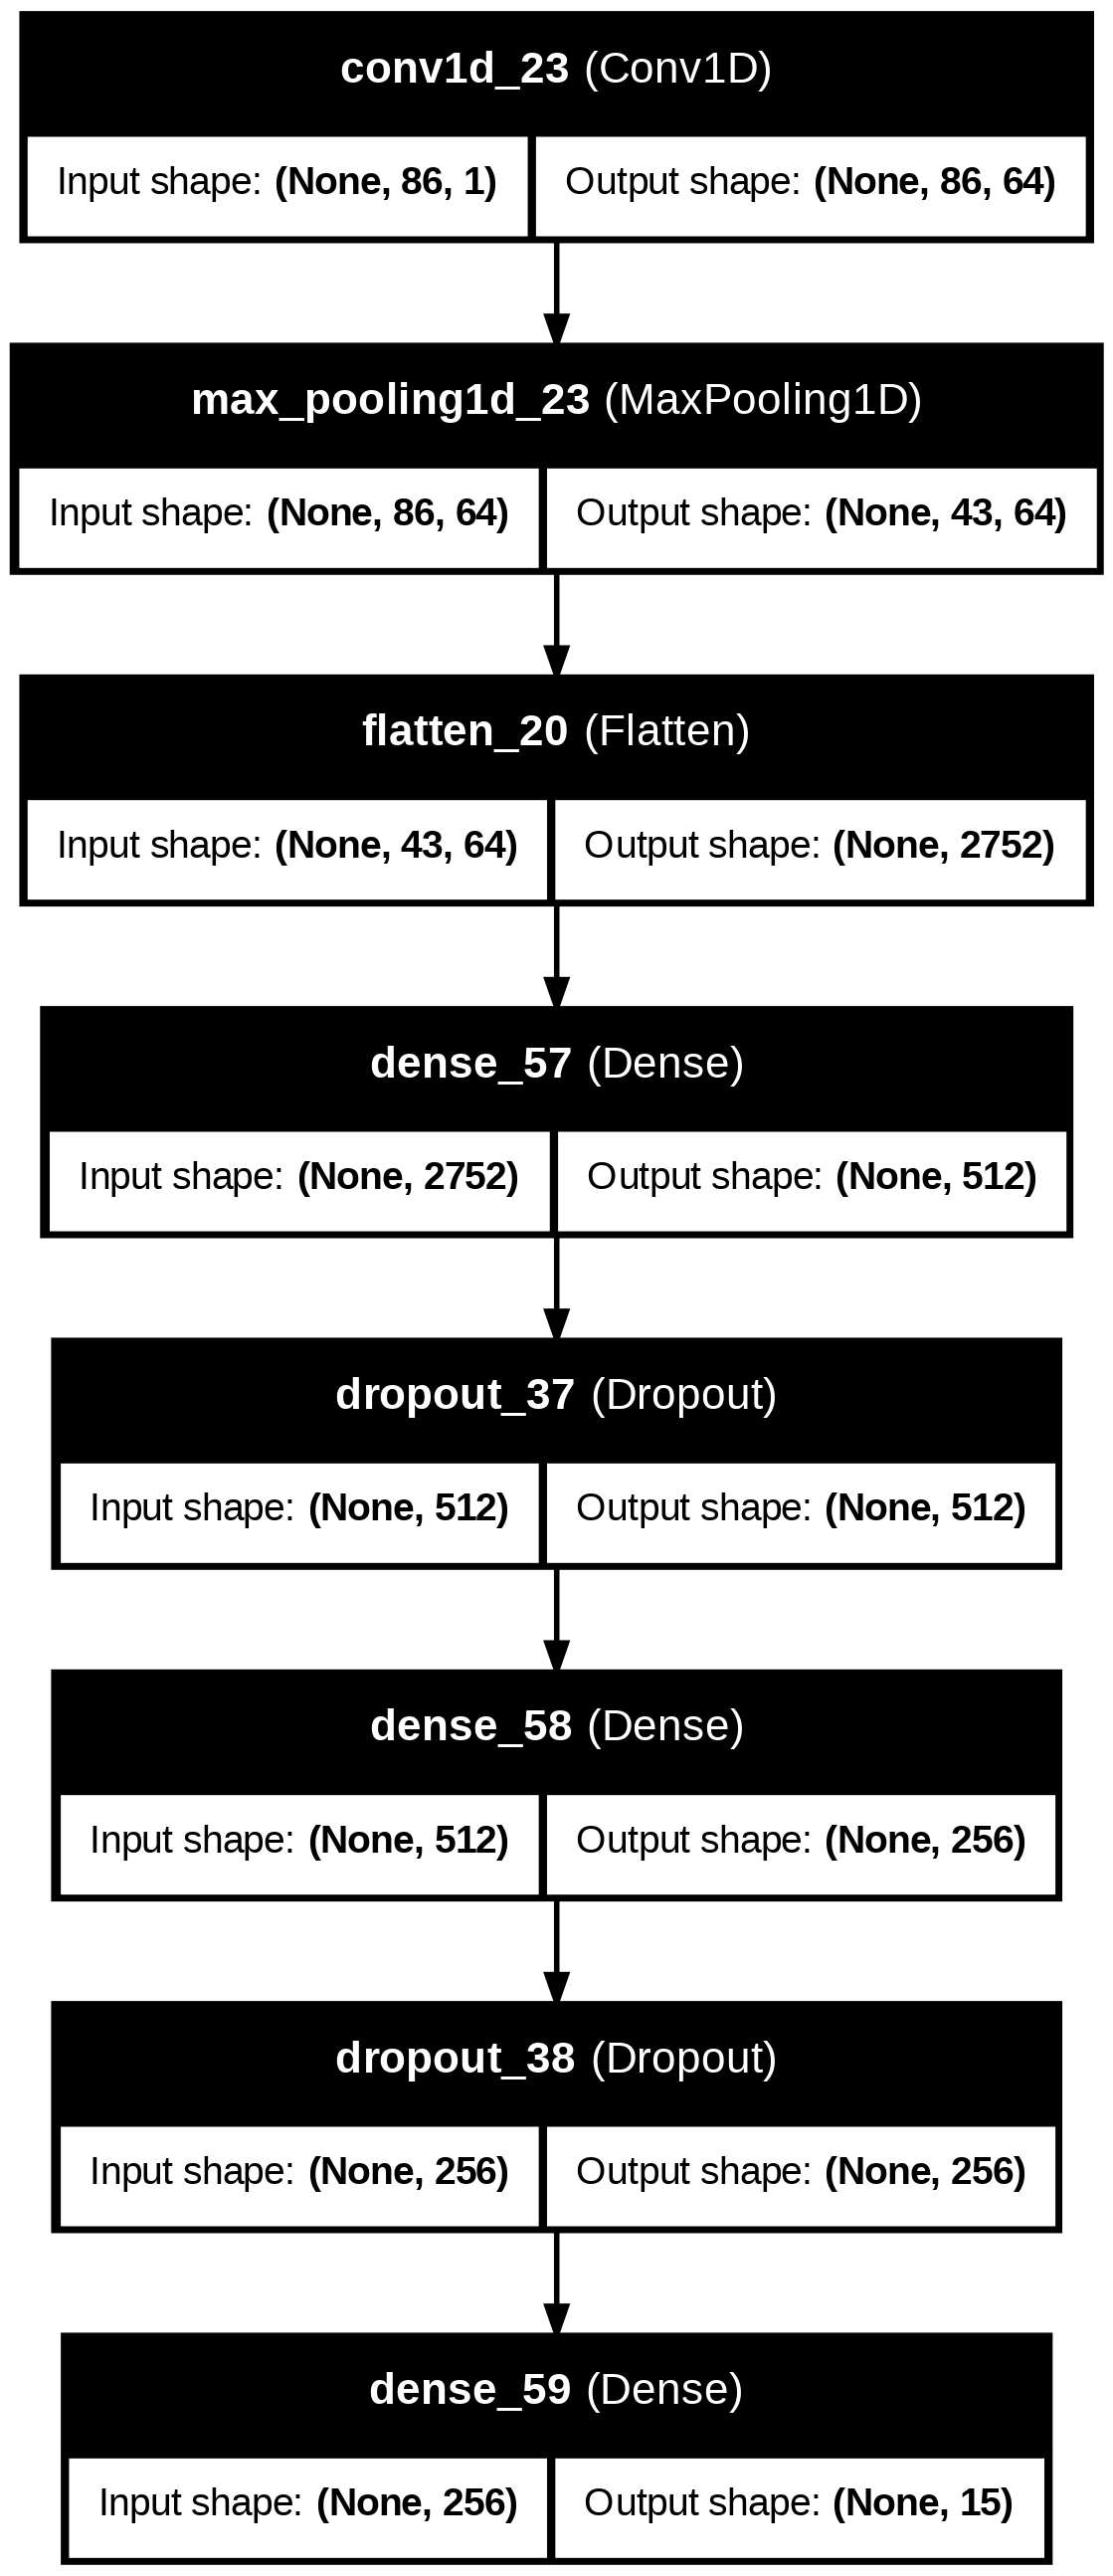

In [17]:
# Vẽ kiến trúc mô hình
plot_model(best_model, to_file='cnn_pso_model.png', show_shapes=True, show_layer_names=True)

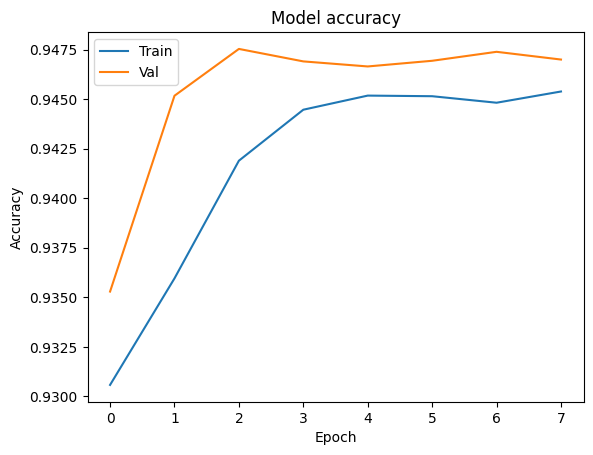

<Figure size 640x480 with 0 Axes>

In [18]:
# Vẽ biểu đồ độ chính xác huấn luyện và xác thực
plt.plot(best_model_history['accuracy'])
plt.plot(best_model_history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.savefig('acc_plot.png')

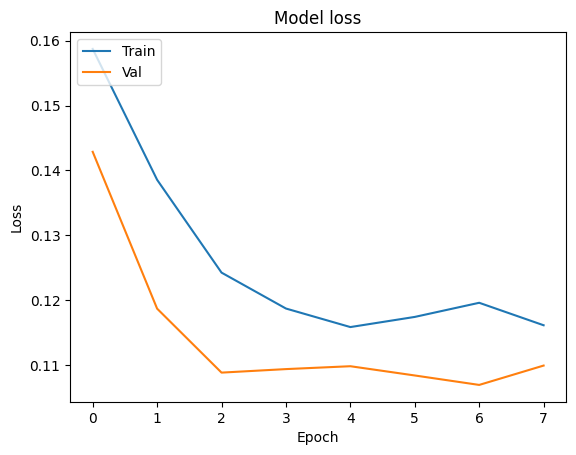

<Figure size 640x480 with 0 Axes>

In [19]:
# Vẽ biểu đồ mất mát huấn luyện và xác thực
plt.plot(best_model_history['loss'])
plt.plot(best_model_history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.savefig('los_plot.png')

In [20]:
# Đánh giá mô hình trên tập huấn luyện
train_metrics = best_model.evaluate(X_train, y_train, verbose=1)

42036/42036 ━━━━━━━━━━━━━━━━━━━━ 85s 2ms/step - accuracy: 0.9472 - f1: 0.7793 - loss: 0.1091 - precision: 0.9815 - recall: 0.9221


In [21]:
# Đánh giá mô hình trên tập xác thực
val_metrics = best_model.evaluate(X_val, y_val, verbose=1)

6006/6006 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9473 - f1: 0.7818 - loss: 0.1098 - precision: 0.9815 - recall: 0.9218


In [22]:
# Đánh giá mô hình trên tập kiểm tra
start_time = time.time()
print("Model performance on test dataset:")
test_metrics = best_model.evaluate(X_test, y_test, verbose=1)
end_time = time.time()
test_time = end_time - start_time
print(f"Thời gian đánh giá mô hình: {test_time:.2f} giây")

Model performance on test dataset:
12011/12011 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9469 - f1: 0.7795 - loss: 0.1086 - precision: 0.9817 - recall: 0.9224
Thời gian đánh giá mô hình: 25.36 giây


In [23]:
# Dự đoán trên tập kiểm tra
start_time = time.time()
y_pred = best_model.predict(X_test)
total_inference_time = time.time() - start_time
print(f"\nTổng thời gian dự đoán cho tập kiểm tra: {total_inference_time:.4f} giây")

12011/12011 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step

Tổng thời gian dự đoán cho tập kiểm tra: 21.2098 giây


In [24]:
# Tính thời gian suy luận trung bình cho mỗi mẫu
num_samples = X_test.shape[0]
avg_inference_time = (total_inference_time / num_samples) * 1000  # chuyển đổi sang mili giây
print(f"\nThời gian suy luận trung bình trên mỗi mẫu: {avg_inference_time:.6f} ms")


Thời gian suy luận trung bình trên mỗi mẫu: 0.055187 ms


In [25]:
# Báo cáo phân loại
print(classification_report(y_test, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      4805
           1       0.75      0.92      0.83      9709
           2       1.00      0.99      1.00     13588
           3       0.81      1.00      0.89     10013
           4       1.00      1.00      1.00     24314
           5       0.79      0.80      0.79      1706
           6       1.00      1.00      1.00       712
           7       1.00      1.00      1.00    272800
           8       0.93      0.17      0.29      9987
           9       1.00      0.49      0.66      3995
          10       1.00      0.90      0.94      2156
          11       0.91      0.19      0.32     10165
          12       1.00      0.28      0.44      7361
          13       0.94      0.84      0.89     10005
          14       1.00      0.03      0.05      3013

   micro avg       0.98      0.92      0.95    384329
   macro avg       0.94      0.70      0.74    384329
weighted avg       0.98   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


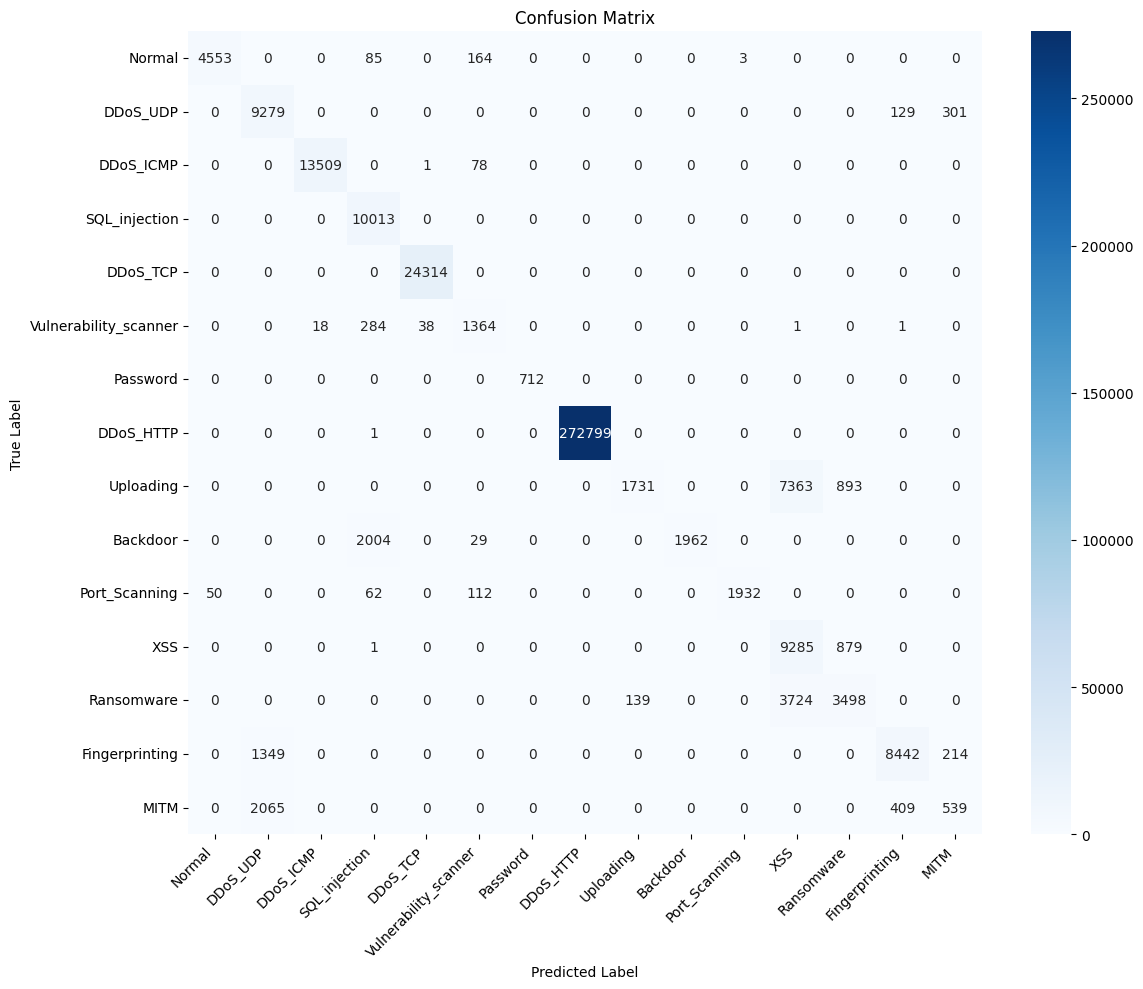

In [26]:
# Ma trận nhầm lẫn
# Lấy nhãn các lớp
class_labels = [
    'Normal', 'DDoS_UDP', 'DDoS_ICMP', 'SQL_injection', 'DDoS_TCP', 
    'Vulnerability_scanner', 'Password', 'DDoS_HTTP', 'Uploading', 
    'Backdoor', 'Port_Scanning', 'XSS', 'Ransomware', 
    'Fingerprinting', 'MITM'
]

# Chuyển đổi dự đoán sang nhãn lớp
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Tạo ma trận nhầm lẫn
conf_mat = confusion_matrix(y_test_classes, y_pred_classes)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(12, 10))  # Điều chỉnh kích thước để hiển thị rõ
sns.heatmap(
    conf_mat, 
    annot=True,  # Hiển thị số lượng 
    fmt='d',     # Định dạng số nguyên
    cmap='Blues', 
    xticklabels=class_labels, 
    yticklabels=class_labels
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')  # Xoay nhãn trục x để dễ đọc
plt.tight_layout()  # Điều chỉnh bố cục để không bị cắt nhãn
plt.savefig('confusion_matrix.png')
plt.show()

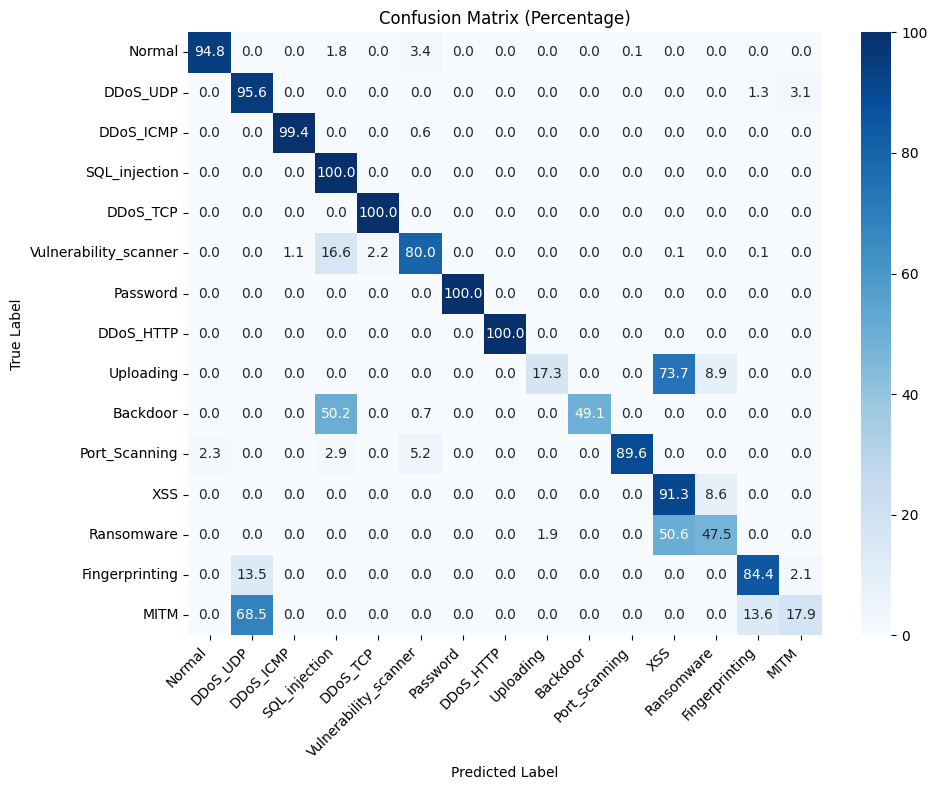

In [27]:
# Ma trận nhầm lẫn với tỷ lệ phần trăm
# Chuyển đổi sang tỷ lệ phần trăm
conf_mat_percent = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis] * 100

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(10, 8))  # Tăng kích thước để hiển thị rõ
sns.heatmap(
    conf_mat_percent, 
    annot=True,  # Hiển thị số liệu 
    fmt='.1f',   # Định dạng 1 chữ số thập phân
    cmap='Blues', 
    xticklabels=class_labels, 
    yticklabels=class_labels
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentage)')
plt.xticks(rotation=45, ha='right')  # Xoay nhãn trục x để dễ đọc
plt.tight_layout()  # Điều chỉnh bố cục để không bị cắt nhãn
plt.savefig('confusion_matrix_percentage.png')
plt.show()

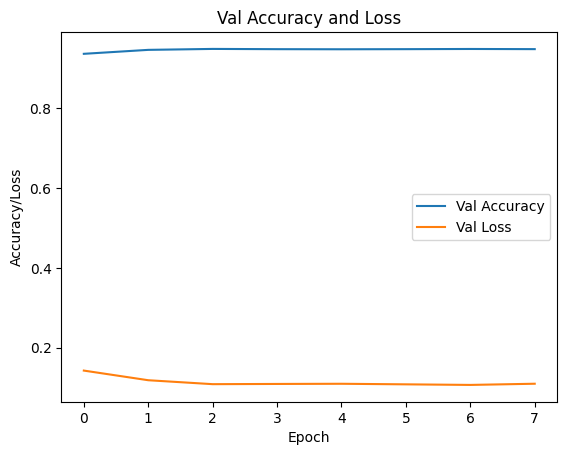

<Figure size 640x480 with 0 Axes>

In [28]:
# Độ chính xác và mất mát trên tập kiểm tra qua các epoch
test_acc = best_model_history['val_accuracy']
test_loss = best_model_history['val_loss']
plt.plot(test_acc, label='Val Accuracy')
plt.plot(test_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.title('Val Accuracy and Loss')
plt.legend()
plt.show()
plt.savefig('val_acc_los.png')